In [1]:
import numpy as np
import tables, pylab, sys, operator,dashi, os
import glob
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from icecube import NewNuFlux, dataclasses,astro
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_curve,precision_recall_curve
import lightgbm as lgb

RuntimeError: FATAL: module compiled as little endian, but detected different endianness at runtime

In [2]:
Data_postcut_2 = np.load('/data/user/xk35/BDT/2016/Precut_files/Data_post_cut_gamma_2.7_24days_train_cc.npy')
MC_postcut_2 = np.load('/data/user/xk35/BDT/2016/Precut_files/MC_post_cut_gamma_2.7_3000_cc.npy')
print(len(Data_postcut_2))
print(len(MC_postcut_2))

156878
39448


In [3]:
GC_ra , GC_dec = astro.gal_to_equa(0., 0.)
maskgc = ((Data_postcut_2['spMPE_zenith']-np.radians(90.))>GC_dec-np.radians(10)) & ((Data_postcut_2['spMPE_zenith']-np.radians(90.))<GC_dec+np.radians(10))
Data_gc = Data_postcut_2[maskgc]
maskgc2 = ((MC_postcut_2['spMPE_zenith']-np.radians(90.))>GC_dec-np.radians(10)) & ((MC_postcut_2['spMPE_zenith']-np.radians(90.))<GC_dec+np.radians(10))
MC_gc = MC_postcut_2[maskgc2]

In [4]:
# 2d array for features

def  Feat(MC , Data ):
    Features = np.zeros((len(MC) + len(Data),15))

    Features.T[0][:] = np.concatenate((MC['spMPE_ndirE'],Data['spMPE_ndirE']))
    Features.T[1][:] = np.concatenate((MC['spMPE_rlogl'],Data['spMPE_rlogl']))
    Features.T[2][:] = np.concatenate((MC['spMPE_parabo'],Data['spMPE_parabo']))
    Features.T[3][:] = np.concatenate((MC['MPEHighNoise_delta_angle'],Data['MPEHighNoise_delta_angle']))
    Features.T[4][:] = np.concatenate((MC['logE'],Data['logE']))
    Features.T[5][:] = np.concatenate((MC['BayesLLHRatio'],Data['BayesLLHRatio']))
    Features.T[6][:] = np.concatenate((MC['cog_r2'],Data['cog_r2']))
    Features.T[7][:] = np.concatenate((MC['cog_z'],Data['cog_z']))
    Features.T[8][:] = np.concatenate((MC['spMPE_ldirE'],Data['spMPE_ldirE']))
    Features.T[9][:] = np.concatenate((MC['LineFit_delta_angle'],Data['LineFit_delta_angle']))
    Features.T[10][:] = np.concatenate((MC['NEarlyNCh'],Data['NEarlyNCh']))
    Features.T[11][:] = np.concatenate((MC['logMuEx'],Data['logMuEx']))
    Features.T[12][:] = np.concatenate((MC['MuExrllt'],Data['MuExrllt']))



    #this feature is to track MC weights after train test split
    Features.T[13][:] = np.concatenate((MC['weights'], 10*np.ones(len(Data))))
    #track zenith of events
    Features.T[14][:] = np.concatenate((MC['spMPE_zenith'],Data['spMPE_zenith']))
    
    Event_Type = np.concatenate((np.ones(len(MC)), np.zeros(len(Data))))
    
    return Features, Event_Type

In [5]:
def Feat_weight_zen(X_train, X_test):
    # pull out mc weights from train and test datasets
    X_train_weights = X_train.T[13]
    mask_mc = (X_train_weights != 10)
    X_train_weights = X_train_weights[mask_mc]

    X_train_zenith = X_train.T[14]
    X_train_MC_zenith = X_train_zenith[mask_mc]
    
    X_test_weights = X_test.T[13]
    mask_mc = (X_test_weights != 10)
    X_test_weights = X_test_weights[mask_mc]
    
    X_test_zenith = X_test.T[14]
    X_test_MC_zenith = X_test_zenith[mask_mc]
    
    return X_train_weights, X_test_weights, X_train_MC_zenith, X_test_MC_zenith, mask_mc

def prep_train_Feat(Features, X_train, X_test):
    

    
    #get rid of weights and zenith before training
    Features = np.delete(Features, [-1,-2], axis = 1)
    X_train = np.delete(X_train, [-1,-2], axis = 1)
    X_test = np.delete(X_test, [-1,-2], axis = 1)

    return Features, X_train, X_test

In [6]:
#Features, Event_Type = Feat(MC_postcut_2, Data_postcut_2)
Features, Event_Type = Feat(MC_gc, Data_gc)

#train test split
X_train, X_test, y_train, y_test = train_test_split(Features, Event_Type, test_size = 0.5, random_state = 1)

#np.save('BDT_Features.npy', Features)

In [7]:
#make test data something else
set_test = False

if set_test == True:
    Data_test = np.load('Data0301_post_cut_gamma_2.7.npy')
    
    MC_test = MC_postcut_2[:len(Data_test)]
    Features_0601, Event_Type = Feat(MC_postcut_2, Data_test)
    _, X_test, _, y_test = train_test_split(Features_0601, Event_Type, test_size = 0.99, random_state = 1)
    
    
#process feature
X_train_weights, X_test_weights, X_train_MC_zenith, X_test_MC_zenith, mask_mc = Feat_weight_zen(X_train, X_test)
    
Features, X_train, X_test = prep_train_Feat(Features, X_train, X_test)

In [8]:
df = pd.DataFrame(data=Features, columns=['spMPE_ndirE', 'spMPE_rlogl', 'spMPE_parabo',
                                         'MPEHighNoise_delta_angle', 'logE', 
                                          'BayesLLHRatio', 
                                         'cog_r2','cog_z','spMPE_ldirE','LineFit_delta_angle', 'NEarlyNCh' 
                                         ,'logMuEx', 'MuExrllt'
                                         ])

#early stop to check if over training by checking if test score starts to go down


DecisionTreeClassifier
XGBClassifier


/home/xk35/.local/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:49:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBRFClassifier
[11:50:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
LGBMClassifier


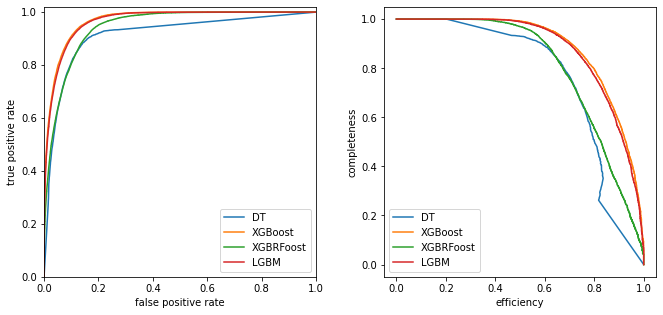

In [9]:
def compute_models(*args):
    names = []
    probs = []
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(X_train, y_train)
        
        #Note that we are outputing the probabilities [of class 1], not the classes
        y_probs = clf.predict_proba(X_test)[:, 1]

        names.append(classifier.__name__)
        probs.append(y_probs)

    return names, probs

dt = RandomForestClassifier(max_depth = 3, ccp_alpha=30, max_samples=1, min_samples_split=20)
LGBMClassifier = lgb.LGBMClassifier

names, probs = compute_models((DecisionTreeClassifier,dict(max_depth=12,criterion='entropy')),
                              #(AdaBoostClassifier, dict(base_estimator = dt, n_estimators = 150)),
                              (XGBClassifier, dict(n_estimators = 150,eta=0.1, max_depth=6)),
                              (XGBRFClassifier, dict(n_estimators = 150, learning_rate = 0.1, max_depth=6,
                                                       subsample=0.8, colsample_bynode=0.277)),
                              (LGBMClassifier, dict(num_leaves=10, learning_rate = 0.5, n_estimators = 150))
                              
                             )

#------------------------------------------------------------
# Plot ROC curves and completeness/efficiency
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

# ax1 will show roc curves
ax1 = plt.subplot(121)

# ax2 will show precision/recall
ax2 = plt.subplot(122)

# ax3 will show completeness/efficiency
#ax3 = plt.subplot(133)

labels = dict(DecisionTreeClassifier='DT',
              #AdaBoostClassifier='AdaBoost',
              XGBClassifier='XGBoost',
              XGBRFClassifier='XGBRFoost',
              LGBMClassifier = 'LGBM')

thresholds = np.linspace(0, 1, 1001)[:-1]

# iterate through and show results
for name, y_prob in zip(names, probs):
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    precision, recall, thresh2 = precision_recall_curve(y_test, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])

    ax1.plot(fpr, tpr, label=labels[name])

    #See note above about astroML vs. sklearn
    #Note that the range of threshhold values here is 0% to 100% (0.0 to 1.0)
    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    #for i, t in enumerate(thresholds):
        #y_pred = (y_prob >= t)
       # comp[i], cont[i] = completeness_contamination(y_pred, y_test)
    #ax2.plot(1 - cont, comp, label=labels[name])
    
    ax2.plot(precision, recall, label=labels[name])

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1.02)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.legend(loc=4)

#ax2.set_xlabel('efficiency')
#ax2.set_ylabel('completeness')
#ax2.set_xlim(0, 1.0)
#ax2.set_ylim(0.2, 1.02)

ax2.set_xlabel('efficiency')
ax2.set_ylabel('completeness')
#ax2.set_xlim(0.6, 1.0)
#ax2.set_ylim(0.6, 1.02)
ax2.legend(loc=3)

plt.show()

In [ ]:
name_cutcurve, prob_cutcurve = compute_models(
    (XGBClassifier, dict(n_estimators = 700,eta=0.1, max_depth=12))
    #(XGBRFClassifier, dict(n_estimators = 700, learning_rate = 0.1, subsample=0.8, 
     #                      colsample_bynode=0.277, max_depth=12))                                 

                              #lighhtgbm gradientboost
        #(DecisionTreeClassifier,dict(max_depth=12,criterion='entropy'))
                             )

MC_score = prob_cutcurve[0][y_test == 1]

Data_score = prob_cutcurve[0][y_test == 0]

XGBClassifier


/home/xk35/.local/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:50:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
#plot efficiency
score_mins = np.r_[np.linspace(0, .9, 200), 1 - np.logspace(-5, -1,100)[::-1]]                
sig_eff = [X_test_weights[MC_score > score_min].sum()/X_test_weights.sum() for score_min in score_mins]                                                                                             
                                                                                                      
data_eff = [(Data_score[Data_score > score_min]).sum()/Data_score.sum() for score_min in score_mins]                                                                                                
                                                                                                      
plt.plot(sig_eff, data_eff)
plt.yscale('log')
plt.ylim(10**-4, 1)
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Efficiency')